## loading packages

In [1]:
import pandas as pd
import numpy as np
import sklearn as skl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sc
from sklearn.metrics import roc_auc_score
import gc #importing garbage collector
import time
from scipy import signal

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline  

SEED = 42
#Pandas - Displaying more rorws and columns
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)

## memory reduction

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

## loading data <a class="anchor" id="data"></a>

In [3]:
def dataloader():
    df_train = pd.read_csv('data/sales_train_validation.csv')
    df_prices = pd.read_csv('data/sell_prices.csv')
    df_days = pd.read_csv('data/calendar.csv')
    submission_sample = pd.read_csv('data/sample_submission.csv')

    df_train = reduce_mem_usage(df_train)
    df_prices = reduce_mem_usage(df_prices)
    df_days = reduce_mem_usage(df_days)
    return submission_sample, df_train, df_prices, df_days

submission_sample, df_train, df_prices, df_days = dataloader()

Mem. usage decreased to 95.00 Mb (78.7% reduction)
Mem. usage decreased to 130.48 Mb (37.5% reduction)
Mem. usage decreased to  0.12 Mb (41.9% reduction)


In [4]:
df_train.head(1)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,d_41,d_42,d_43,d_44,d_45,d_46,d_47,d_48,d_49,d_50,d_51,d_52,d_53,d_54,d_55,d_56,d_57,d_58,d_59,d_60,d_61,d_62,d_63,d_64,d_65,d_66,d_67,d_68,d_69,d_70,d_71,d_72,d_73,d_74,d_75,d_76,d_77,d_78,d_79,d_80,d_81,d_82,d_83,d_84,d_85,d_86,d_87,d_88,d_89,d_90,d_91,d_92,d_93,d_94,d_95,d_96,d_97,d_98,d_99,d_100,d_101,d_102,d_103,d_104,d_105,d_106,d_107,d_108,d_109,d_110,d_111,d_112,d_113,d_114,d_115,d_116,d_117,d_118,d_119,d_120,d_121,d_122,d_123,d_124,d_125,d_126,d_127,d_128,d_129,d_130,d_131,d_132,d_133,d_134,d_135,d_136,d_137,d_138,d_139,d_140,d_141,d_142,d_143,d_144,d_145,d_146,d_147,d_148,d_149,d_150,d_151,d_152,d_153,d_154,d_155,d_156,d_157,d_158,d_159,d_160,d_161,d_162,d_163,d_164,d_165,d_166,d_167,d_168,d_169,d_170,d_171,d_172,d_173,d_174,d_175,d_176,d_177,d_178,d_179,d_180,d_181,d_182,d_183,d_184,d_185,d_186,d_187,d_188,d_189,d_190,d_191,d_192,d_193,d_194,d_195,d_196,d_197,d_198,d_199,d_200,d_201,d_202,d_203,d_204,d_205,d_206,d_207,d_208,d_209,d_210,d_211,d_212,d_213,d_214,d_215,d_216,d_217,d_218,d_219,d_220,d_221,d_222,d_223,d_224,d_225,d_226,d_227,d_228,d_229,d_230,d_231,d_232,d_233,d_234,d_235,d_236,d_237,d_238,d_239,d_240,d_241,d_242,d_243,d_244,...,d_1664,d_1665,d_1666,d_1667,d_1668,d_1669,d_1670,d_1671,d_1672,d_1673,d_1674,d_1675,d_1676,d_1677,d_1678,d_1679,d_1680,d_1681,d_1682,d_1683,d_1684,d_1685,d_1686,d_1687,d_1688,d_1689,d_1690,d_1691,d_1692,d_1693,d_1694,d_1695,d_1696,d_1697,d_1698,d_1699,d_1700,d_1701,d_1702,d_1703,d_1704,d_1705,d_1706,d_1707,d_1708,d_1709,d_1710,d_1711,d_1712,d_1713,d_1714,d_1715,d_1716,d_1717,d_1718,d_1719,d_1720,d_1721,d_1722,d_1723,d_1724,d_1725,d_1726,d_1727,d_1728,d_1729,d_1730,d_1731,d_1732,d_1733,d_1734,d_1735,d_1736,d_1737,d_1738,d_1739,d_1740,d_1741,d_1742,d_1743,d_1744,d_1745,d_1746,d_1747,d_1748,d_1749,d_1750,d_1751,d_1752,d_1753,d_1754,d_1755,d_1756,d_1757,d_1758,d_1759,d_1760,d_1761,d_1762,d_1763,d_1764,d_1765,d_1766,d_1767,d_1768,d_1769,d_1770,d_1771,d_1772,d_1773,d_1774,d_1775,d_1776,d_1777,d_1778,d_1779,d_1780,d_1781,d_1782,d_1783,d_1784,d_1785,d_1786,d_1787,d_1788,d_1789,d_1790,d_1791,d_1792,d_1793,d_1794,d_1795,d_1796,d_1797,d_1798,d_1799,d_1800,d_1801,d_1802,d_1803,d_1804,d_1805,d_1806,d_1807,d_1808,d_1809,d_1810,d_1811,d_1812,d_1813,d_1814,d_1815,d_1816,d_1817,d_1818,d_1819,d_1820,d_1821,d_1822,d_1823,d_1824,d_1825,d_1826,d_1827,d_1828,d_1829,d_1830,d_1831,d_1832,d_1833,d_1834,d_1835,d_1836,d_1837,d_1838,d_1839,d_1840,d_1841,d_1842,d_1843,d_1844,d_1845,d_1846,d_1847,d_1848,d_1849,d_1850,d_1851,d_1852,d_1853,d_1854,d_1855,d_1856,d_1857,d_1858,d_1859,d_1860,d_1861,d_1862,d_1863,d_1864,d_1865,d_1866,d_1867,d_1868,d_1869,d_1870,d_1871,d_1872,d_1873,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,2,0,2,2,0,0,0,1,1,0,2,0,1,1,2,0,1,0,0,0,2,1,0,1,1,2,0,0,0,0,0,0,0,1,0,1,0,1,0,3,1,1,0,1,1,2,0,0,0,0,1,1,0,0,0,0,3,0,1,0,0,0,0,1,1,1,0,1,0,2,0,0,0,0,2,0,0,0,0,1,1,2,0,0,0,0,2,0,0,1,1,1,1,0,0,0,0,0,1,2,2,0,1,0,0,0,0,1,2,1,0,0,0,0,0,1,0,3,0,1,2,1,0,3,0,0,0,1,0,2,2,1,0,0,1,2,0,1

## visualizations on different level

In [5]:
series_cols = df_train.columns[df_train.columns.str.contains("d_")].values
level_cols = df_train.columns[df_train.columns.str.contains("d_")==False].values

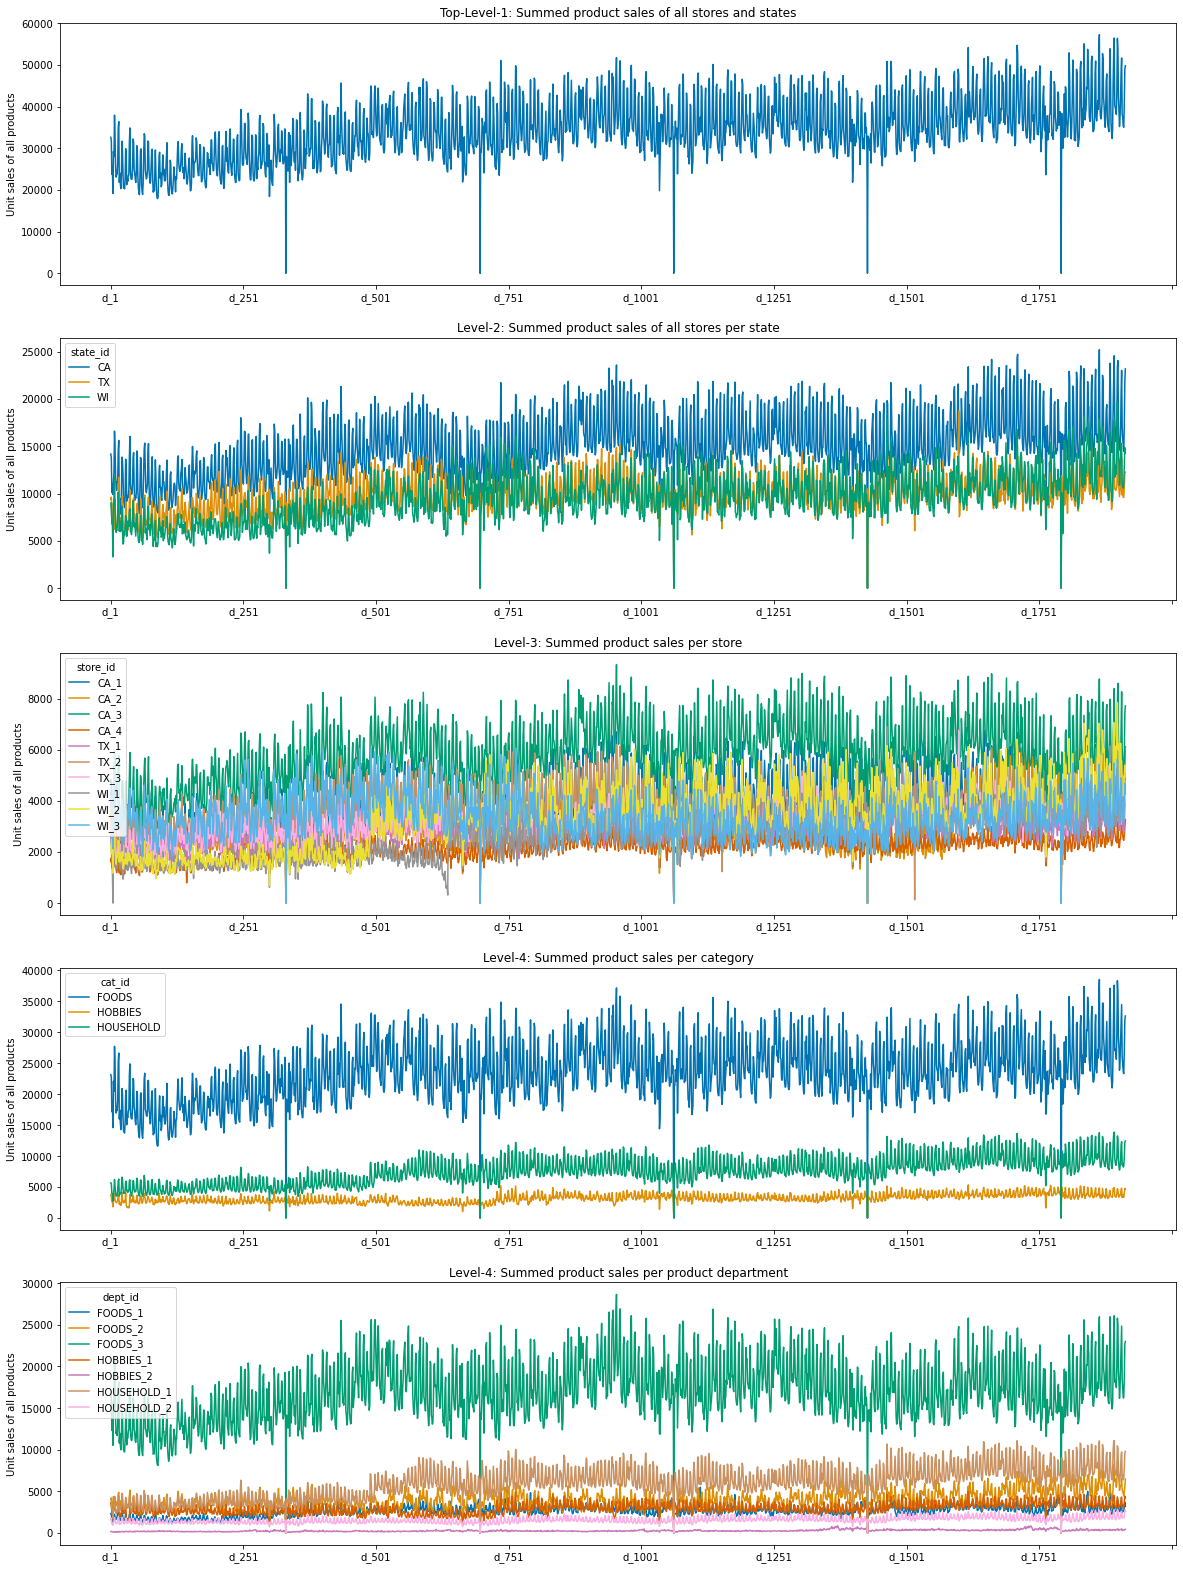

In [6]:
sns.set_palette("colorblind")

fig, ax = plt.subplots(5,1,figsize=(20,28))
df_train[series_cols].sum().plot(ax=ax[0])
ax[0].set_title("Top-Level-1: Summed product sales of all stores and states")
ax[0].set_ylabel("Unit sales of all products");
df_train.groupby("state_id")[series_cols].sum().transpose().plot(ax=ax[1])
ax[1].set_title("Level-2: Summed product sales of all stores per state");
ax[1].set_ylabel("Unit sales of all products");
df_train.groupby("store_id")[series_cols].sum().transpose().plot(ax=ax[2])
ax[2].set_title("Level-3: Summed product sales per store")
ax[2].set_ylabel("Unit sales of all products");
df_train.groupby("cat_id")[series_cols].sum().transpose().plot(ax=ax[3])
ax[3].set_title("Level-4: Summed product sales per category")
ax[3].set_ylabel("Unit sales of all products");
df_train.groupby("dept_id")[series_cols].sum().transpose().plot(ax=ax[4])
ax[4].set_title("Level-4: Summed product sales per product department")
ax[4].set_ylabel("Unit sales of all products");

## data preprocessing

In [7]:
temp_series = df_train
peak_days = []
x = np.count_nonzero(temp_series==0, axis=0)
peaks, _ = sc.signal.find_peaks(x, height=np.quantile(x,0.75), threshold=max(x)/25)
peak_days = temp_series.columns[peaks]
df_days[df_days['d'].isin(peak_days)]

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
299,2011-11-24,11143,Thursday,6,11,2011,d_300,Thanksgiving,National,NaN,NaN,0,0,0
330,2011-12-25,11148,Sunday,2,12,2011,d_331,Christmas,National,NaN,NaN,0,0,0
663,2012-11-22,11243,Thursday,6,11,2012,d_664,Thanksgiving,National,NaN,NaN,0,0,0
696,2012-12-25,11248,Tuesday,4,12,2012,d_697,Christmas,National,NaN,NaN,0,0,0
1034,2013-11-28,11344,Thursday,6,11,2013,d_1035,Thanksgiving,National,NaN,NaN,0,0,0
1061,2013-12-25,11348,Wednesday,5,12,2013,d_1062,Christmas,National,NaN,NaN,0,0,0
1398,2014-11-27,11443,Thursday,6,11,2014,d_1399,Thanksgiving,National,NaN,NaN,0,0,0
1426,2014-12-25,11447,Thursday,6,12,2014,d_1427,Christmas,National,NaN,NaN,0,0,0
1762,2015-11-26,11543,Thursday,6,11,2015,d_1763,Thanksgiving,National,NaN,NaN,0,0,0
1791,2015-12-25,11547,Friday,7,12,2015,d_1792,Christmas,National,NaN,NaN,0,0,0


In [8]:
peak_days_before=[]
peak_days_after=[]

for i, days in enumerate(peak_days):
    peak_days_before.append('d_'+str(np.int(peak_days[i][2:])-1))
    peak_days_after.append('d_'+str(np.int(peak_days[i][2:])+1))
    
df_train_no_outlier = df_train.copy().T[1:]
df_train_no_outlier.columns = df_train.T.iloc[0]

for x,y,z in zip(peak_days,peak_days_before,peak_days_after):
        df_train_no_outlier[df_train_no_outlier.index==x] = np.reshape([pd.concat([df_train_no_outlier[df_train_no_outlier.index==y],df_train_no_outlier[df_train_no_outlier.index==z]],axis=0).mean()],(1,30490))

df_train_no_outlier = df_train_no_outlier.T.reset_index()
df_train_no_outlier = pd.concat([df_train_no_outlier[level_cols],df_train_no_outlier[series_cols].apply(pd.to_numeric,downcast='float')],axis=1)
df_train_no_outlier = reduce_mem_usage(df_train_no_outlier)

Mem. usage decreased to 112.65 Mb (49.7% reduction)


In [ ]:
del temp_series, peak_days_before, peak_days_after, peak_days, peaks, df_train

## aggeregation

In [12]:
Level1 = pd.DataFrame(df_train_no_outlier[series_cols].sum(),columns={'Total'}).T
Level2 = df_train_no_outlier.groupby("state_id")[series_cols].sum()
Level3 = df_train_no_outlier.groupby("store_id")[series_cols].sum()
Level4 = df_train_no_outlier.groupby("cat_id")[series_cols].sum()
Level5 = df_train_no_outlier.groupby("dept_id")[series_cols].sum()

Level6 = df_train_no_outlier.groupby(["state_id",'cat_id'])[series_cols].sum().reset_index()
Level6['index']=''
for row in range(len(Level6)):
    Level6['index'][row]=str(Level6['state_id'][row])+'_'+str(Level6['cat_id'][row])
Level6.set_index(Level6['index'],inplace=True)
Level6.drop(['state_id','cat_id','index'],axis=1,inplace=True)

Level7 = df_train_no_outlier.groupby(["state_id",'dept_id'])[series_cols].sum().reset_index()
Level7['index']=''
for row in range(len(Level7)):
    Level7['index'][row]=str(Level7['state_id'][row])+'_'+str(Level7['dept_id'][row])
Level7.set_index(Level7['index'],inplace=True)
Level7.drop(['state_id','dept_id','index'],axis=1,inplace=True)

Level8 = df_train_no_outlier.groupby(["store_id",'cat_id'])[series_cols].sum().reset_index()
Level8['index']=''
for row in range(len(Level8)):
    Level8['index'][row]=str(Level8['store_id'][row])+'_'+str(Level8['cat_id'][row])
Level8.set_index(Level8['index'],inplace=True)
Level8.drop(['store_id','cat_id','index'],axis=1,inplace=True)

Level9 = df_train_no_outlier.groupby(["store_id",'dept_id'])[series_cols].sum().reset_index()
Level9['index']=''
for row in range(len(Level9)):
    Level9['index'][row]=str(Level9['store_id'][row])+'_'+str(Level9['dept_id'][row])
Level9.set_index(Level9['index'],inplace=True)
Level9.drop(['store_id','dept_id','index'],axis=1,inplace=True)

Level10= df_train_no_outlier.groupby(["item_id"])[series_cols].sum()


Level11= df_train_no_outlier.groupby(["item_id",'state_id'])[series_cols].sum().reset_index()
Level11['index']=''
for row in range(len(Level11)):
    Level11['index'][row]=str(Level11['item_id'][row])+'_'+str(Level11['state_id'][row])
Level11.set_index(Level11['index'],inplace=True)
Level11.drop(['item_id','state_id','index'],axis=1,inplace=True)


Level12= df_train_no_outlier.copy()
Level12.set_index(Level12['id'],inplace=True, drop =True)
Level12.drop(level_cols,axis=1,inplace=True)

df=pd.concat([Level1,Level2,Level3,Level4,Level5,Level6,Level7,Level8,Level9,Level10,Level11,Level12])

del Level1,Level2,Level3,Level4,Level5,Level6,Level7,Level8,Level9,Level10,Level11,Level12

In [13]:
df.shape

(42840, 1913)

In [14]:
df.head()

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,d_41,d_42,d_43,d_44,d_45,d_46,d_47,d_48,d_49,d_50,d_51,d_52,d_53,d_54,d_55,d_56,d_57,d_58,d_59,d_60,d_61,d_62,d_63,d_64,d_65,d_66,d_67,d_68,d_69,d_70,d_71,d_72,d_73,d_74,d_75,d_76,d_77,d_78,d_79,d_80,d_81,d_82,d_83,d_84,d_85,d_86,d_87,d_88,d_89,d_90,d_91,d_92,d_93,d_94,d_95,d_96,d_97,d_98,d_99,d_100,d_101,d_102,d_103,d_104,d_105,d_106,d_107,d_108,d_109,d_110,d_111,d_112,d_113,d_114,d_115,d_116,d_117,d_118,d_119,d_120,d_121,d_122,d_123,d_124,d_125,d_126,d_127,d_128,d_129,d_130,d_131,d_132,d_133,d_134,d_135,d_136,d_137,d_138,d_139,d_140,d_141,d_142,d_143,d_144,d_145,d_146,d_147,d_148,d_149,d_150,d_151,d_152,d_153,d_154,d_155,d_156,d_157,d_158,d_159,d_160,d_161,d_162,d_163,d_164,d_165,d_166,d_167,d_168,d_169,d_170,d_171,d_172,d_173,d_174,d_175,d_176,d_177,d_178,d_179,d_180,d_181,d_182,d_183,d_184,d_185,d_186,d_187,d_188,d_189,d_190,d_191,d_192,d_193,d_194,d_195,d_196,d_197,d_198,d_199,d_200,d_201,d_202,d_203,d_204,d_205,d_206,d_207,d_208,d_209,d_210,d_211,d_212,d_213,d_214,d_215,d_216,d_217,d_218,d_219,d_220,d_221,d_222,d_223,d_224,d_225,d_226,d_227,d_228,d_229,d_230,d_231,d_232,d_233,d_234,d_235,d_236,d_237,d_238,d_239,d_240,d_241,d_242,d_243,d_244,d_245,d_246,d_247,d_248,d_249,d_250,...,d_1664,d_1665,d_1666,d_1667,d_1668,d_1669,d_1670,d_1671,d_1672,d_1673,d_1674,d_1675,d_1676,d_1677,d_1678,d_1679,d_1680,d_1681,d_1682,d_1683,d_1684,d_1685,d_1686,d_1687,d_1688,d_1689,d_1690,d_1691,d_1692,d_1693,d_1694,d_1695,d_1696,d_1697,d_1698,d_1699,d_1700,d_1701,d_1702,d_1703,d_1704,d_1705,d_1706,d_1707,d_1708,d_1709,d_1710,d_1711,d_1712,d_1713,d_1714,d_1715,d_1716,d_1717,d_1718,d_1719,d_1720,d_1721,d_1722,d_1723,d_1724,d_1725,d_1726,d_1727,d_1728,d_1729,d_1730,d_1731,d_1732,d_1733,d_1734,d_1735,d_1736,d_1737,d_1738,d_1739,d_1740,d_1741,d_1742,d_1743,d_1744,d_1745,d_1746,d_1747,d_1748,d_1749,d_1750,d_1751,d_1752,d_1753,d_1754,d_1755,d_1756,d_1757,d_1758,d_1759,d_1760,d_1761,d_1762,d_1763,d_1764,d_1765,d_1766,d_1767,d_1768,d_1769,d_1770,d_1771,d_1772,d_1773,d_1774,d_1775,d_1776,d_1777,d_1778,d_1779,d_1780,d_1781,d_1782,d_1783,d_1784,d_1785,d_1786,d_1787,d_1788,d_1789,d_1790,d_1791,d_1792,d_1793,d_1794,d_1795,d_1796,d_1797,d_1798,d_1799,d_1800,d_1801,d_1802,d_1803,d_1804,d_1805,d_1806,d_1807,d_1808,d_1809,d_1810,d_1811,d_1812,d_1813,d_1814,d_1815,d_1816,d_1817,d_1818,d_1819,d_1820,d_1821,d_1822,d_1823,d_1824,d_1825,d_1826,d_1827,d_1828,d_1829,d_1830,d_1831,d_1832,d_1833,d_1834,d_1835,d_1836,d_1837,d_1838,d_1839,d_1840,d_1841,d_1842,d_1843,d_1844,d_1845,d_1846,d_1847,d_1848,d_1849,d_1850,d_1851,d_1852,d_1853,d_1854,d_1855,d_1856,d_1857,d_1858,d_1859,d_1860,d_1861,d_1862,d_1863,d_1864,d_1865,d_1866,d_1867,d_1868,d_1869,d_1870,d_1871,d_1872,d_1873,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
Total,32640.0,31760.0,23776.0,25424.0,19136.0,29216.0,28016.0,37952.0,32736.0,25584.0,23056.0,23664.0,23760.0,26448.0,34848.0,36384.0,21808.0,24080.0,21440.0,20320.0,23712.0,31696.0,29280.0,23952.0,20496.0,20752.0,20288.0,22528.0,29904.0,28704.0,21232.0,22880.0,22048.0,23488.0,23568.0,31200.0,34880.0,24576.0,22752.0,22560.0,22624.0,25568.0,32208.0,31424.0,24928.0,24016.0,22768.0,21776.0,23856.0,30608.0,29632.0,23104.0,20496.0,19232.0,18848.0,23360.0,29616.0,29872.0,21440.0,19584.0,18928.0,21744.0,28320.0,33472.0,33056.0,24848.0,23568.0,22656.0,22896.0,24768.0,31744.0,31520.0,24816.0,23216.0,21616.0,21952.0,25472.0,29232.0,29792.0,22400.0,19472.0,20192.0,19776.0,24272.0,29568.0,24032.0,20000.0,18112.0,17920.0,18144.0,22720.0,28096.0,29040.0,22848.0,24096.0,20768.0,21184.0,24480.0,28400.0,23696.0,25024.0,22224.0,22176.0,22416.0,25648.0,28736.0

## feature engineering

In [15]:
startDay = 0
df_days["date"] = pd.to_datetime(df_days['date'])
df_days.set_index('date', inplace=True)
df_days['is_event_day'] = [1 if x ==False else 0 for x in df_days['event_name_1'].isnull()] 
df_days['is_event_day'] = df_days['is_event_day'].astype(np.int8)
day_before_event = df_days[df_days['is_event_day']==1].index.shift(-1,freq='D')
df_days['is_event_day_before'] = 0
df_days['is_event_day_before'][df_days.index.isin(day_before_event)] = 1
df_days['is_event_day_before'] = df_days['is_event_day_before'].astype(np.int8)
daysBeforeEventTest = df_days['is_event_day_before'][1913:1941]
daysBeforeEvent = df_days['is_event_day_before'][startDay:1913]
daysBeforeEvent.index = df_train_no_outlier.index[startDay:1913]
daysBeforeEventValid = df_days['is_event_day_before'][1941:]
del day_before_event

In [16]:
df_days

,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,is_event_day,is_event_day_before
date,,,,,,,,,,,,,,,
2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,0,0
2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0,0,0
2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0,0,0
2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0,0,0
2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-06-15,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1,0,0
2016-06-16,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0,0,0
2016-06-17,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0,0,0


In [17]:
from sklearn.preprocessing import OrdinalEncoder

def prep_calendar(df):
    df = df.drop([ "weekday"], axis=1)
    df = df.assign(d = df.d.str[2:].astype(int))
    df = df.fillna("missing")
    cols = list(set(df.columns) - {"wm_yr_wk", "d"})
    df[cols] = OrdinalEncoder(dtype="int").fit_transform(df[cols])
    df = reduce_mem_usage(df)
    return df

df_days = prep_calendar(df_days)

Mem. usage decreased to  0.05 Mb (78.2% reduction)


In [18]:
df_days

,wm_yr_wk,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,is_event_day,is_event_day_before
date,,,,,,,,,,,,,,
2011-01-29,11101,0,0,0,1,30,4,4,2,0,0,0,0,0
2011-01-30,11101,1,0,0,2,30,4,4,2,0,0,0,0,0
2011-01-31,11101,2,0,0,3,30,4,4,2,0,0,0,0,0
2011-02-01,11101,3,1,0,4,30,4,4,2,1,1,0,0,0
2011-02-02,11101,4,1,0,5,30,4,4,2,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-06-15,11620,4,5,5,1965,30,4,4,2,0,1,1,0,0
2016-06-16,11620,5,5,5,1966,30,4,4,2,0,0,0,0,0
2016-06-17,11620,6,5,5,1967,30,4,4,2,0,0,0,0,0


In [19]:
cat_cols = ["wday", "month", "year", "event_name_1", 
            "event_type_1", "event_name_2", "event_type_2",
            "is_event_day_before", "snap_CA", "snap_TX", "snap_WI"]
features = df_days[cat_cols]
features_test = features.iloc[1941:,:]
features_train = features.iloc[startDay:1941]
df_final = pd.concat([df.T.reset_index(drop=True).iloc[startDay:1941,:], features.iloc[startDay:1941,:].reset_index(drop=True)], axis = 1)
numeric_cols = df_final[df_final.columns.difference(cat_cols)].columns

In [20]:
df_final

,Total,CA,TX,WI,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,WI_3,FOODS,HOBBIES,HOUSEHOLD,FOODS_1,FOODS_2,FOODS_3,HOBBIES_1,HOBBIES_2,HOUSEHOLD_1,HOUSEHOLD_2,CA_FOODS,CA_HOBBIES,CA_HOUSEHOLD,TX_FOODS,TX_HOBBIES,TX_HOUSEHOLD,WI_FOODS,WI_HOBBIES,WI_HOUSEHOLD,CA_FOODS_1,CA_FOODS_2,CA_FOODS_3,CA_HOBBIES_1,CA_HOBBIES_2,CA_HOUSEHOLD_1,CA_HOUSEHOLD_2,TX_FOODS_1,TX_FOODS_2,TX_FOODS_3,TX_HOBBIES_1,TX_HOBBIES_2,TX_HOUSEHOLD_1,TX_HOUSEHOLD_2,WI_FOODS_1,WI_FOODS_2,WI_FOODS_3,WI_HOBBIES_1,WI_HOBBIES_2,WI_HOUSEHOLD_1,WI_HOUSEHOLD_2,CA_1_FOODS,CA_1_HOBBIES,CA_1_HOUSEHOLD,CA_2_FOODS,CA_2_HOBBIES,CA_2_HOUSEHOLD,CA_3_FOODS,CA_3_HOBBIES,CA_3_HOUSEHOLD,CA_4_FOODS,CA_4_HOBBIES,CA_4_HOUSEHOLD,TX_1_FOODS,TX_1_HOBBIES,TX_1_HOUSEHOLD,TX_2_FOODS,TX_2_HOBBIES,TX_2_HOUSEHOLD,TX_3_FOODS,TX_3_HOBBIES,TX_3_HOUSEHOLD,WI_1_FOODS,WI_1_HOBBIES,WI_1_HOUSEHOLD,WI_2_FOODS,WI_2_HOBBIES,WI_2_HOUSEHOLD,WI_3_FOODS,WI_3_HOBBIES,WI_3_HOUSEHOLD,CA_1_FOODS_1,CA_1_FOODS_2,CA_1_FOODS_3,CA_1_HOBBIES_1,CA_1_HOBBIES_2,CA_1_HOUSEHOLD_1,CA_1_HOUSEHOLD_2,CA_2_FOODS_1,CA_2_FOODS_2,CA_2_FOODS_3,CA_2_HOBBIES_1,CA_2_HOBBIES_2,CA_2_HOUSEHOLD_1,CA_2_HOUSEHOLD_2,CA_3_FOODS_1,CA_3_FOODS_2,CA_3_FOODS_3,CA_3_HOBBIES_1,CA_3_HOBBIES_2,CA_3_HOUSEHOLD_1,CA_3_HOUSEHOLD_2,CA_4_FOODS_1,CA_4_FOODS_2,CA_4_FOODS_3,CA_4_HOBBIES_1,CA_4_HOBBIES_2,CA_4_HOUSEHOLD_1,CA_4_HOUSEHOLD_2,TX_1_FOODS_1,TX_1_FOODS_2,TX_1_FOODS_3,TX_1_HOBBIES_1,TX_1_HOBBIES_2,TX_1_HOUSEHOLD_1,TX_1_HOUSEHOLD_2,TX_2_FOODS_1,TX_2_FOODS_2,TX_2_FOODS_3,TX_2_HOBBIES_1,TX_2_HOBBIES_2,TX_2_HOUSEHOLD_1,TX_2_HOUSEHOLD_2,TX_3_FOODS_1,TX_3_FOODS_2,TX_3_FOODS_3,TX_3_HOBBIES_1,TX_3_HOBBIES_2,TX_3_HOUSEHOLD_1,TX_3_HOUSEHOLD_2,WI_1_FOODS_1,WI_1_FOODS_2,WI_1_FOODS_3,WI_1_HOBBIES_1,WI_1_HOBBIES_2,WI_1_HOUSEHOLD_1,WI_1_HOUSEHOLD_2,WI_2_FOODS_1,WI_2_FOODS_2,WI_2_FOODS_3,WI_2_HOBBIES_1,WI_2_HOBBIES_2,WI_2_HOUSEHOLD_1,WI_2_HOUSEHOLD_2,WI_3_FOODS_1,WI_3_FOODS_2,WI_3_FOODS_3,WI_3_HOBBIES_1,WI_3_HOBBIES_2,WI_3_HOUSEHOLD_1,WI_3_HOUSEHOLD_2,FOODS_1_001,FOODS_1_002,FOODS_1_003,FOODS_1_004,FOODS_1_005,FOODS_1_006,FOODS_1_008,FOODS_1_009,FOODS_1_010,FOODS_1_011,FOODS_1_012,FOODS_1_013,FOODS_1_014,FOODS_1_015,FOODS_1_016,FOODS_1_017,FOODS_1_018,FOODS_1_019,FOODS_1_020,FOODS_1_021,FOODS_1_022,FOODS_1_023,FOODS_1_024,FOODS_1_025,FOODS_1_026,FOODS_1_027,FOODS_1_028,FOODS_1_029,FOODS_1_030,FOODS_1_031,FOODS_1_032,FOODS_1_033,FOODS_1_034,FOODS_1_035,FOODS_1_036,FOODS_1_037,FOODS_1_038,FOODS_1_039,FOODS_1_040,FOODS_1_041,FOODS_1_042,FOODS_1_043,FOODS_1_044,FOODS_1_045,FOODS_1_046,FOODS_1_047,FOODS_1_048,FOODS_1_049,FOODS_1_050,FOODS_1_051,FOODS_1_052,FOODS_1_053,FOODS_1_054,FOODS_1_055,FOODS_1_056,FOODS_1_057,FOODS_1_058,FOODS_1_059,FOODS_1_060,FOODS_1_061,FOODS_1_062,FOODS_1_063,FOODS_1_064,FOODS_1_065,FOODS_1_066,FOODS_1_067,FOODS_1_068,FOODS_1_069,FOODS_1_070,FOODS_1_071,FOODS_1_072,FOODS_1_073,FOODS_1_074,FOODS_1_075,FOODS_1_076,FOODS_1_077,FOODS_1_078,FOODS_1_079,FOODS_1_080,FOODS_1_081,FOODS_1_082,FOODS_1_083,FOODS_1_084,FOODS_1_085,FOODS_1_086,FOODS_1_087,FOODS_1_088,FOODS_1_089,FOODS_1_090,FOODS_1_091,FOODS_1_092,FOODS_1_093,FOODS_1_094,FOODS_1_095,FOODS_1_096,FOODS_1_097,...,FOODS_3_586_WI_3_validation,FOODS_3_587_WI_3_validation,FOODS_3_588_WI_3_validation,FOODS_3_589_WI_3_validation,FOODS_3_590_WI_3_validation,FOODS_3_591_WI_3_validation,FOODS_3_592_WI_3_validation,FOODS_3_593_WI_3_validation,FOODS_3_594_WI_3_validation,FOODS_3_595_WI_3_validation,FOODS_3_596_WI_3_validation,FOODS_3_597_WI_3_validation,FOODS_3_598_WI_3_validation,FOODS_3_599_WI_3_validation,FOODS_3_600_WI_3_validation,FOODS_3_601_WI_3_validation,FOODS_3_602_WI_3_validation,FOODS_3_603_WI_3_validation,FOODS_3_604_WI_3_validation,FOODS_3_605_WI_3_validation,FOODS_3_606_WI_3_validation,FOODS_3_607_WI_3_validation,FOODS_3_608_WI_3_validation,FOODS_3_609_WI_3_validation,FOODS_3_610_WI_3_validation,FOODS_3_611_WI_3_validation,FOODS_3_612_WI_3_validation,FOODS_3_613_WI_3_validation,FOODS_3_614_WI_3_validation,FOODS_3_615_WI_3_validation,FOODS_3_616_WI_3_validation,FOODS_3_617_WI_3_validation,FOOD

In [21]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
dt_scaled = sc.fit_transform(df_final)

In [22]:
gc.collect()

30

## training  data preparing

In [23]:
X_train = []
y_train = []
X_train_categories= {}
timesteps = 14

for cats in cat_cols:
    X_train_categories[cats] = []

for i in range(timesteps, 1941 - startDay):
    X_train.append(dt_scaled[i-timesteps:i,0:42840])
    y_train.append(dt_scaled[i][0:42840])
    
    for z, cats in enumerate(cat_cols):
        X_train_categories[cats].append(dt_scaled[i-timesteps:i,42840+z])
    
X_train = np.array(X_train)
y_train = np.array(y_train)

print('Shape of X_train: '+str(X_train.shape))
print('Shape of y_train: '+str(y_train.shape))
print('Shape of all categorical features: '+str(np.array(X_train_categories[cats]).shape))

Shape of X_train: (1927, 14, 42840)
Shape of y_train: (1927, 42840)
Shape of all categorical features: (1927, 14)


In [24]:
inputs = {}
inputs.update({'numerics': dt_scaled[-timesteps:,:42840]})
for cats in cat_cols:
    inputs[cats] = []

for z, cats in enumerate(cat_cols):
    inputs.update({cats: dt_scaled[-timesteps:,42840+z]})

In [25]:
del df_train_no_outlier, df_prices, df_days, df, dt_scaled

In [26]:
gc.collect()

45

## model construction

In [32]:
import keras
def tilted_loss(q, y, f):
    e = (y - f)
    return keras.backend.mean(keras.backend.maximum(q * e, (q - 1) * e), 
                              axis=-1)

In [33]:
QUANTILES = [0.005, 0.025, 0.165, 0.25, 0.5, 0.75, 0.835, 0.975, 0.995]

In [34]:
EPOCHS = 32
BATCH_SIZE = 32 

In [35]:
from keras.models import Model
from keras.layers import Dense, LSTM, Dropout, Input, Embedding, Flatten, concatenate

In [39]:
#identifying uniques for each of the categorical features
feat_uniques = []
for feats in features.iloc[:,:len(cat_cols)]:
    feat_uniques.append(df_final[feats].nunique())
    
n_steps = X_train.shape[1] # number of timesteps in each sample
n_numerical_feats = len(numeric_cols) # number of numerical features in each sample
cat_size = feat_uniques # number of categories in each categorical feature
cat_embd_dim = list(np.ones(len(cat_cols), dtype=np.int8)) # embedding dimension for each categorical feature

numerical_input = Input(shape=(n_steps, n_numerical_feats), name='numeric_input')

cat_inputs = []
for i,cat in enumerate(cat_cols):
    cat_inputs.append(Input(shape=(n_steps,), name=cat + '_input'))

cat_embedded = []
for i,cat in enumerate(cat_cols):
    embed = Embedding(cat_size[i], cat_embd_dim[i])(cat_inputs[i])
    cat_embedded.append(embed)

cat_merged = concatenate(cat_embedded)
merged = concatenate([numerical_input, cat_merged])

# Adding the first layer
lstm_out = LSTM(40, dropout=0.2, return_sequences=True, input_shape = (X_train.shape[1], X_train.shape[2]))(merged)
# Adding a second layer
#lstm_out = LSTM(400, dropout=0.2, return_sequences=True)(lstm_out)
# Adding a third layer
lstm_out = LSTM(400, dropout=0.2)(lstm_out)
# Adding the output layer
lstm_out = Dense(units = y_train.shape[1])(lstm_out)

model = Model([numerical_input] + cat_inputs, lstm_out)

print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 wday_input (InputLayer)        [(None, 14)]         0           []                               
                                                                                                  
 month_input (InputLayer)       [(None, 14)]         0           []                               
                                                                                                  
 year_input (InputLayer)        [(None, 14)]         0           []                               
                                                                                                  
 event_name_1_input (InputLayer  [(None, 14)]        0           []                               
 )                                                                                          

In [37]:
def run_model(X_train, y_train, q):
    model.compile(optimizer = 'adam',loss=lambda y, f: tilted_loss(q, y, f))
    
    # To follow at which quantile we are predicting right now  
    print('Running the model for Quantil: '+str(q)+':')
    
    model.fit({'numeric_input': X_train,
               'wday_input': np.array(X_train_categories['wday']),
               'month_input': np.array(X_train_categories['month']),
               'year_input': np.array(X_train_categories['year']),
               'event_name_1_input': np.array(X_train_categories['event_name_1']),
               'event_type_1_input': np.array(X_train_categories['event_type_1']),
               'event_name_2_input': np.array(X_train_categories['event_name_2']),
               'event_type_2_input': np.array(X_train_categories['event_type_2']),
               'is_event_day_before_input': np.array(X_train_categories['is_event_day_before']),
               'snap_CA_input': np.array(X_train_categories['snap_CA']),
               'snap_TX_input': np.array(X_train_categories['snap_TX']),
               'snap_WI_input': np.array(X_train_categories['snap_WI']),
     #          'prices_input': X_train_prices
              }, y_train, epochs = EPOCHS, batch_size = BATCH_SIZE, verbose=2)
    
    
    X_test = inputs.copy()
    prediction = []
    for j in range(timesteps,timesteps + 28):
        predicted_volume = model.predict({'numeric_input': X_test['numerics'][j-timesteps:j].reshape(1, timesteps, 42840),
               'wday_input': X_test['wday'][j-timesteps:j].reshape(1,timesteps,),
               'month_input': X_test['month'][j-timesteps:j].reshape(1,timesteps),
               'year_input': X_test['year'][j-timesteps:j].reshape(1,timesteps,),
               'event_name_1_input': X_test['event_name_1'][j-timesteps:j].reshape(1,timesteps,),
               'event_type_1_input': X_test['event_type_1'][j-timesteps:j].reshape(1,timesteps,),
               'event_name_2_input': X_test['event_name_2'][j-timesteps:j].reshape(1,timesteps,),
               'event_type_2_input': X_test['event_type_2'][j-timesteps:j].reshape(1,timesteps,),
               'is_event_day_before_input': X_test['is_event_day_before'][j-timesteps:j].reshape(1,timesteps,),
               'snap_CA_input': X_test['snap_CA'][j-timesteps:j].reshape(1,timesteps,),
               'snap_TX_input': X_test['snap_TX'][j-timesteps:j].reshape(1,timesteps,),
               'snap_WI_input': X_test['snap_WI'][j-timesteps:j].reshape(1,timesteps,)})
        testInput = np.column_stack((np.array(predicted_volume), np.array(features_test.iloc[j-timesteps,:]).reshape(1,11)))
        numerics = np.append(X_test['numerics'],predicted_volume).reshape(j + 1,42840)
        X_test.update({'numerics': numerics})
        for i, key in enumerate(list(inputs.keys())[1:]):
            feat=[]
            feat = np.append(X_test[key],testInput[:,42840+i])
            X_test.update({key: feat})
        predicted_volume = sc.inverse_transform(testInput)[:,0:42840] #without features
        prediction.append(predicted_volume)
    
    prediction = pd.DataFrame(data=np.array(prediction).reshape(28,42840)).T
    return prediction

## prediction

In [ ]:
predictions = pd.concat(
    [run_model(X_train, y_train, q) 
     for q in QUANTILES])

In [65]:
gc.collect()

216

In [66]:
predictions.shape

(385560, 28)

In [70]:
#copying the predictions *2: first is for prediction, second for evaluation (in the final part we only need evaluation)
submission = pd.concat((predictions, predictions), ignore_index=True)

idColumn = submission_sample[["id"]]    
submission[["id"]] = idColumn  

#re-arranging collumns
cols = list(submission.columns)
cols = cols[-1:] + cols[:-1]
submission = submission[cols]
colsname = ["id"] + [f"F{i}" for i in range (1,29)]
submission.columns = colsname

In [71]:
submission.to_csv("data/submission_lstm.csv", index=False)